In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/eth_courses/Autumn22/nlp/spanningtrees/

/content/drive/MyDrive/eth_courses/Autumn22/nlp/spanningtrees


In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
!apt install -y graphviz
!pip install graphviz torch torchtext transformers datasets conllu 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 8.4 MB/s 
     |████████████████████████████████| 365 kB 57.0 MB/s 
     |████████████████████████████████| 596 kB 45.3 MB/s 
     |████████████████████████████████| 101 kB 14.2 MB/s 
     |████████████████████████████████| 6.6 MB 42.1 MB/s 
     |████████████████████████████████| 212 kB 76.0 MB/s 
     |████████████████████████████████| 141 kB 72.2 MB/s 
     |████████████████████████████████| 115 kB 49.4 MB/s 
     |████████████████████████████████| 127 kB 77.9 MB/s 
  Attempting uninstall: urllib3
  

In [5]:
from benji_transformer_play import *

scorer = Scorer2().to(device)
scorer.load_state_dict(torch.load('runs/colab_07_21-14_26_16/save_epoch29.pt', map_location=device))

data = datasets.load_dataset("universal_dependencies", "en_gum")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
val_data = [sequence for sequence in data['test'] if len(sequence['tokens']) < 20]
model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True).to(device)

<All keys matched successfully>

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/4287 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/784 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/890 [00:00<?, ? examples/s]

Dataset universal_dependencies downloaded and prepared to /root/.cache/huggingface/datasets/universal_dependencies/en_gum/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
input_data = val_data[:4]
sentences_embedding, sentences_word_embeddings, targets = get_embeddings(input_data, tokenizer, model)
i = 0
word_embeddings, sentence_embedding, target = sentences_word_embeddings[i], sentences_embedding[i], targets[i]



loss, pred, constr, mst_prob, mst_neg_log_prob, target_prob, target_neg_log_probs = train_on_sentence(word_embeddings, sentence_embedding, target, scorer)

input_data[i]['tokens']
constr
input_data[i]['head']

target_np = target.detach().cpu().numpy()
np.all(target_np == constr[1:])

['The',
 'prevalence',
 'of',
 'discrimination',
 'across',
 'racial',
 'groups',
 'in',
 'contemporary',
 'America',
 ':']

array([-1,  2,  0,  4,  2,  7,  7,  4, 10, 10,  4,  2])

['2', '0', '4', '2', '7', '7', '2', '10', '10', '2', '2']

False

['The', 'prevalence', 'of', 'discrimination', 'across', 'racial', 'groups', 'in', 'contemporary', 'America', ':']


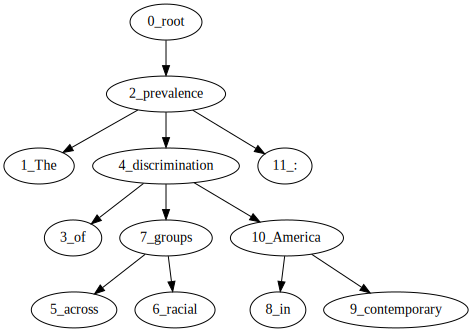

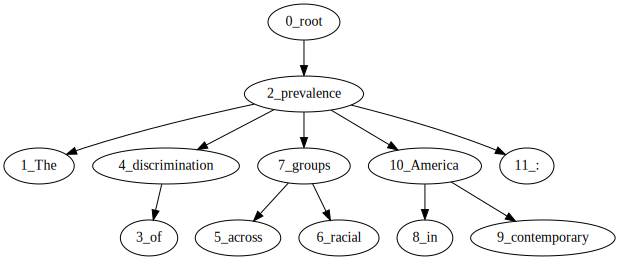

In [7]:
import graphviz

def get_graphviz(tokens, dep_to_head):
  G = graphviz.Digraph()
  tokens = ['root'] + tokens
  # print(tokens)
  for i, token in enumerate(tokens):
    G.node('q' + str(i), str(i) + '_' + token)

  for dep_i, head_i in enumerate(dep_to_head):
    h, d = tokens[head_i], tokens[dep_i + 1]
    # print(h, d)
    G.edge('q' + str(head_i), 'q' + str(dep_i + 1))
  return G

G1 = get_graphviz(input_data[0]['tokens'], constr[1:])
print(input_data[0]['tokens'])
G2 = get_graphviz(input_data[0]['tokens'], list(target.detach().numpy()))
G1
G2

In [8]:
big_mat = scorer(torch.concat([sentence_embedding, word_embeddings]), tanh=False)

mat = big_mat[1:, 1:]  # nxn word head x dep scores
r = big_mat[0, 1:]  # n root -> word scores


torch.Size([12, 11])

9
0


<BarContainer object of 50 artists>

<BarContainer object of 1 artists>

Text(0.5, 0, '50 beams search sorted by score')

Text(0, 0.5, 'dep tree edge factored score sum')

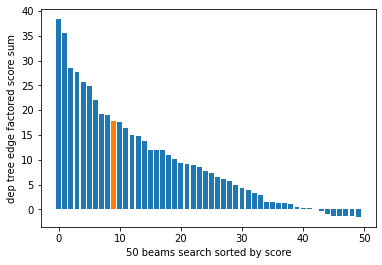

In [9]:
extended_mat = torch.concat([r.unsqueeze(dim=0), mat], dim=0)
extended_mat.shape

extended_mat_np = extended_mat.detach().cpu().numpy()

bs_out = beam_search_matrix(extended_mat_np, n_beam=50)

parses = [triple[1] for triple in bs_out]

correct = [np.all(parse == target_np) for parse in parses]
correct_i = np.where(correct)[0]
correct_i = correct_i[0] if len(correct_i) != 0 else None

mst_correct = [np.all(parse == constr[1:]) for parse in parses]
mst_correct_i = np.where(mst_correct)[0]
mst_correct_i = mst_correct_i[0] if len(mst_correct_i) != 0 else None

print(correct_i)
print(mst_correct_i)

import matplotlib.pyplot as plt
plt.bar(list(range(len(parses))), [triple[2] for triple in bs_out])
plt.bar(correct_i, bs_out[correct_i][2])
plt.xlabel('50 beams search sorted by score')
plt.ylabel('dep tree edge factored score sum')

# G_beam_searches = [get_graphviz(input_data[0]['tokens'], list(parse)) for parse in parses]
# for G, triple in zip(G_beam_searches, bs_out):
#   G
#   print(f"score: {triple[2]}")
# G_beam_searches[0]
# bs_out[0][2]
# G_beam_searches[1]
# bs_out[1][2]
# G_beam_searches[2]
# bs_out[2][2]

9

In [21]:
import tqdm
mst_matches = []
mst_percent_matches = []
for j in tqdm.tqdm(range(len(val_data))):
  input_data = val_data[j:j+2]
  sentences_embedding, sentences_word_embeddings, targets = get_embeddings(input_data, tokenizer, model)
  i = 0
  word_embeddings, sentence_embedding, target = sentences_word_embeddings[i], sentences_embedding[i], targets[i]

  loss, pred, constr, mst_prob, mst_neg_log_prob, target_prob, target_neg_log_probs = train_on_sentence(word_embeddings, sentence_embedding, target, scorer)

  target_np = target.detach().cpu().numpy()
  mst_match = np.all(target_np == constr[1:])

  mst_percent_match = np.sum(target_np == constr[1:])/len(target_np == constr[1:])
  mst_matches.append(mst_match)
  mst_percent_matches.append(mst_percent_match)

  # big_mat = scorer(torch.concat([sentence_embedding, word_embeddings]), tanh=False)

  # mat = big_mat[1:, 1:]  # nxn word head x dep scores
  # r = big_mat[0, 1:]  # n root -> word scores

  # extended_mat = torch.concat([r.unsqueeze(dim=0), mat], dim=0)
  # extended_mat_np = extended_mat.detach().cpu().numpy()

  # bs_out = beam_search_matrix(extended_mat_np, n_beam=10)

  # parses = [triple[1] for triple in bs_out]

  # correct = [np.all(parse == target_np) for parse in parses]
  # correct_i = np.where(correct)[0]
  # correct_i = correct_i[0] if len(correct_i) != 0 else None

  # mst_correct = [np.all(parse == constr[1:]) for parse in parses]
  # mst_correct_i = np.where(mst_correct)[0]
  # mst_correct_i = mst_correct_i[0] if len(mst_correct_i) != 0 else None

  # stats.append((mst_matches, correct_i, mst_correct_i))



100%|█████████▉| 539/540 [01:37<00:00,  5.53it/s]


IndexError: ignored

In [22]:
np.mean(mst_matches),
np.mean(mst_percent_matches)

(0.4137291280148423,)

0.860245413947086

In [ ]:
import tqdm
bs_mst_matches = []
bs_mst_percent_matches = []
for num_beams in range(1, 6):
  print(f'num_beams: {num_beams}')
  bs_mst_matches.append([])
  bs_mst_percent_matches.append([])
  for j in tqdm.tqdm(range(len(val_data) -1)):
    input_data = val_data[j:j+2]
    sentences_embedding, sentences_word_embeddings, targets = get_embeddings(input_data, tokenizer, model)
    i = 0
    word_embeddings, sentence_embedding, target = sentences_word_embeddings[i], sentences_embedding[i], targets[i]

    loss, pred, constr, mst_prob, mst_neg_log_prob, target_prob, target_neg_log_probs = train_on_sentence(word_embeddings, sentence_embedding, target, scorer)


    big_mat = scorer(torch.concat([sentence_embedding, word_embeddings]), tanh=False)

    mat = big_mat[1:, 1:]  # nxn word head x dep scores
    r = big_mat[0, 1:]  # n root -> word scores

    extended_mat = torch.concat([r.unsqueeze(dim=0), mat], dim=0)
    extended_mat_np = extended_mat.detach().cpu().numpy()

    bs_out = beam_search_matrix(extended_mat_np, n_beam=num_beams)


    bs_parse = bs_out[0][1]
    bs_mst_match = np.all(bs_parse == constr[1:])
    bs_mst_percent_match = np.sum(bs_parse == constr[1:])/len(bs_parse == constr[1:])

    bs_mst_matches[-1].append(bs_mst_match)
    bs_mst_percent_matches[-1].append(bs_mst_percent_match)


    # parses = [triple[1] for triple in bs_out]


    # mst_correct = [np.all(parse == constr[1:]) for parse in parses]
    # mst_correct_i = np.where(mst_correct)[0]
    # mst_correct_i = mst_correct_i[0] if len(mst_correct_i) != 0 else None



num_beams: 1


 61%|██████    | 327/539 [01:01<00:55,  3.82it/s]

In [25]:
for a, b in zip(bs_mst_matches, bs_mst_percent_matches):
  print(np.mean(a), np.mean(b))

0.9 0.9732142857142858
0.95 0.9875
0.95 0.9875


(array([15., 23.,  4.,  1.,  1.,  2.,  1.,  1.,  1.,  1.]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 <a list of 10 Patch objects>)

<BarContainer object of 1 artists>

Text(0.5, 0, 'beam number of ground truth dep tree out of 10 beams')

Text(0, 0.5, 'frequency')

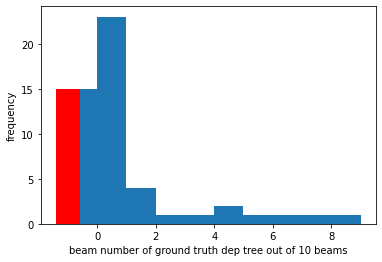

In [ ]:
plt.hist([x[1] for x in stats2])
plt.bar(-1, len([x[1] for x in stats2 if x[1] == -1]), color="red")
plt.xlabel("beam number of ground truth dep tree out of 10 beams")
plt.ylabel("frequency")

In [ ]:
weird = [i for i, x in enumerate(stats2) if x[2] not in [0, -1]]
weird

[]